In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Create directory for saved models if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# 1. Load Dataset
df = pd.read_csv("tox21.csv")  # Replace with your exact filename

In [6]:
# 2. Filter valid SMILES and drop NaNs
df = df[df['smiles'].notnull()]
smiles_list = df['smiles'].tolist()
mol_list = [Chem.MolFromSmiles(sm) for sm in smiles_list]


[23:36:46] WARNING: not removing hydrogen atom without neighbors
[23:36:47] Explicit valence for atom # 8 Al, 6, is greater than permitted
[23:36:47] Explicit valence for atom # 3 Al, 6, is greater than permitted
[23:36:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[23:36:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[23:36:47] Explicit valence for atom # 9 Al, 6, is greater than permitted
[23:36:47] Explicit valence for atom # 5 Al, 6, is greater than permitted
[23:36:48] Explicit valence for atom # 16 Al, 6, is greater than permitted
[23:36:48] Explicit valence for atom # 20 Al, 6, is greater than permitted


In [7]:
# 3. Remove invalid molecules
valid_idx = [i for i, mol in enumerate(mol_list) if mol is not None]
df = df.iloc[valid_idx].reset_index(drop=True)
mol_list = [mol_list[i] for i in valid_idx]

In [8]:
# 4. Generate Morgan Fingerprints
def mol_to_fp(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

fps = [mol_to_fp(mol) for mol in mol_list]
X = np.array([np.array(fp) for fp in fps])

[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerator
[23:37:04] DEPRECATION WARNING: please use MorganGenerat

In [9]:
# 5. Select Toxicity Targets
targets = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

print(f"Found {len(df)} valid molecules. Starting training...")

Found 7823 valid molecules. Starting training...


[NR-AR] Model saved to saved_models/NR_AR_model.pkl
[NR-AR] ROC AUC: 0.7368
[NR-AR-LBD] Model saved to saved_models/NR_AR_LBD_model.pkl
[NR-AR-LBD] ROC AUC: 0.8779
[NR-AhR] Model saved to saved_models/NR_AhR_model.pkl
[NR-AhR] ROC AUC: 0.8963
[NR-Aromatase] Model saved to saved_models/NR_Aromatase_model.pkl
[NR-Aromatase] ROC AUC: 0.8195
[NR-ER] Model saved to saved_models/NR_ER_model.pkl
[NR-ER] ROC AUC: 0.6858
[NR-ER-LBD] Model saved to saved_models/NR_ER_LBD_model.pkl
[NR-ER-LBD] ROC AUC: 0.8029
[NR-PPAR-gamma] Model saved to saved_models/NR_PPAR_gamma_model.pkl
[NR-PPAR-gamma] ROC AUC: 0.7527
[SR-ARE] Model saved to saved_models/SR_ARE_model.pkl
[SR-ARE] ROC AUC: 0.7880
[SR-ATAD5] Model saved to saved_models/SR_ATAD5_model.pkl
[SR-ATAD5] ROC AUC: 0.8543
[SR-HSE] Model saved to saved_models/SR_HSE_model.pkl
[SR-HSE] ROC AUC: 0.7757
[SR-MMP] Model saved to saved_models/SR_MMP_model.pkl
[SR-MMP] ROC AUC: 0.8461
[SR-p53] Model saved to saved_models/SR_p53_model.pkl
[SR-p53] ROC AUC: 0.

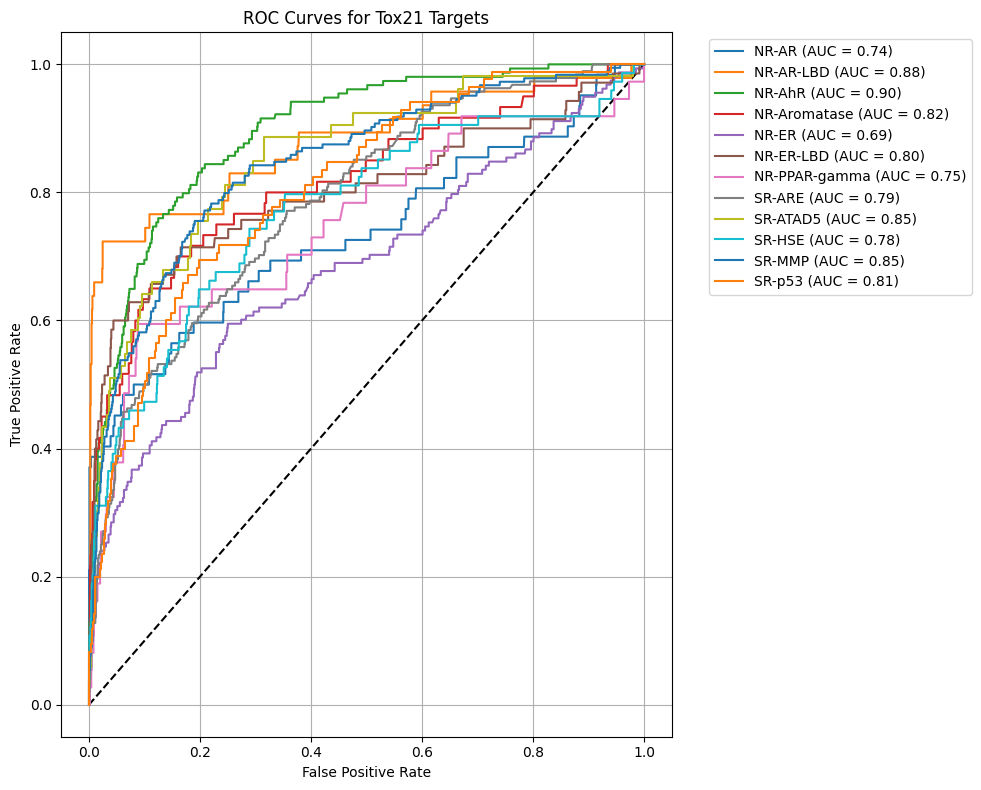

In [10]:
# 6. Train individual model per target
results = {}
models = {}  # To store trained models

# Set up figure for ROC curves
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

for target in targets:
    if target not in df.columns:
        continue

    # Keep rows where the label is not missing and not -1
    target_labels = df[target]
    mask = target_labels.notna() & (target_labels != -1)
    
    y = target_labels[mask].astype(int).values
    X_valid = X[mask.values]

    if len(np.unique(y)) < 2:
        print(f"[{target}] Skipped — not enough class variation.")
        continue

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_valid, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    # Store the model
    models[target] = model
    
    # Save model to pickle file
    pickle_filename = f"saved_models/{target.replace('-', '_')}_model.pkl"
    with open(pickle_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"[{target}] Model saved to {pickle_filename}")

    # Evaluate
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results[target] = auc
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{target} (AUC = {auc:.2f})')

    print(f"[{target}] ROC AUC: {auc:.4f}")

# Customize ROC curve plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tox21 Targets')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Save ROC plot
roc_plot_filename = "tox21_roc_curves.png"
plt.savefig(roc_plot_filename, dpi=300, bbox_inches='tight')
print(f"\nROC curves saved to {roc_plot_filename}")


=== Toxicity Prediction Summary ===
NR-AR          : AUC = 0.7368
NR-AR-LBD      : AUC = 0.8779
NR-AhR         : AUC = 0.8963
NR-Aromatase   : AUC = 0.8195
NR-ER          : AUC = 0.6858
NR-ER-LBD      : AUC = 0.8029
NR-PPAR-gamma  : AUC = 0.7527
SR-ARE         : AUC = 0.7880
SR-ATAD5       : AUC = 0.8543
SR-HSE         : AUC = 0.7757
SR-MMP         : AUC = 0.8461
SR-p53         : AUC = 0.8108
AUC scores bar plot saved to tox21_auc_scores.png

All models saved to saved_models/all_tox21_models.pkl


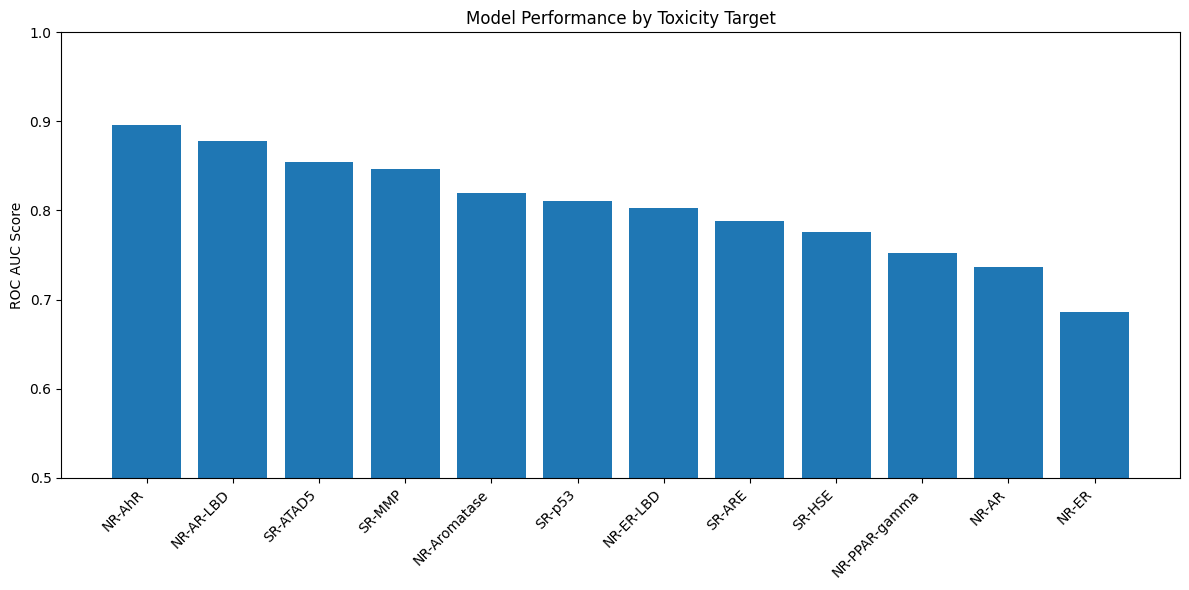

In [11]:
# 7. Summary
print("\n=== Toxicity Prediction Summary ===")
for target, auc in results.items():
    print(f"{target:15s}: AUC = {auc:.4f}")

# Create and save a bar plot of AUC scores
plt.figure(figsize=(12, 6))
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
plt.bar(range(len(sorted_results)), list(sorted_results.values()), align='center')
plt.xticks(range(len(sorted_results)), list(sorted_results.keys()), rotation=45, ha='right')
plt.ylabel('ROC AUC Score')
plt.title('Model Performance by Toxicity Target')
plt.ylim(0.5, 1.0)
plt.tight_layout()

# Save bar plot
bar_plot_filename = "tox21_auc_scores.png"
plt.savefig(bar_plot_filename, dpi=300, bbox_inches='tight')
print(f"AUC scores bar plot saved to {bar_plot_filename}")

# Save all models to a single pickle file (optional)
with open('saved_models/all_tox21_models.pkl', 'wb') as f:
    pickle.dump(models, f)
print("\nAll models saved to saved_models/all_tox21_models.pkl")